## Building a superresolution network

In [1]:
#imports
import jax
import jax.numpy as jnp
from jax import value_and_grad
from jax_cfd.ml import towers
import jax_cfd.ml.train_utils as train_utils

import haiku as hk
import gin
import numpy as np
import xarray
import random

import pickle
from diego_model_utils import SaveObject, forward_pass_module

import matplotlib.pyplot as plt
import seaborn

In [2]:
# import data
file_name = '256x64_150_seconds_inner_1'
data = xarray.open_dataset(f'../creating_dataset/datasets/'+ file_name +'.nc', chunks={'time': '100MB'})


In [3]:
# split by timestamps
x_shape = len(data.x)
y_shape = len(data.y)
high_def = []
for i in range(int(len(data.time))):
    this_time_u = np.array([data.u.isel(time = i)]).reshape(x_shape, y_shape)
    this_time_v = np.array([data.v.isel(time = i)]).reshape(x_shape, y_shape)
    this_time = [this_time_u, this_time_v]
    high_def.append(this_time)

In [4]:
#warm up time (may want to discard initial stages of simulation since not really representative of turbulent flow?)
dt = float(data.time[0].values)

outer_steps = len(data.time.values)

inner_steps = (data.time[1].values-data.time[0].values)/dt

total_sim_time = outer_steps*inner_steps*dt
print("dt: \t\t" + str(dt))
print("outer_steps: \t" + str(outer_steps))
print("inner_steps: \t" + str(inner_steps))
print("total_sim_time: " + str(total_sim_time))

warm_up = 15 #seconds
warm_index = int(warm_up/total_sim_time * outer_steps // 1)
print("removed points: " + str(warm_index))
high_def = high_def[warm_index:]

dt: 		0.015625
outer_steps: 	9600
inner_steps: 	1.0
total_sim_time: 150.0
removed points: 960


In [5]:
high_def = high_def[0::20]

In [6]:
originalMax = np.max(high_def)
originalMin = (np.min(high_def))

In [7]:
print(originalMin,originalMax)

-0.77263814 1.0149648


In [8]:
# scale velocities to beetween zero and one
def scale(input, min=0, max=1):
    
    if min>max:
        raise(ValueError("Min and max may be the wrong way around"))
    
    if min<0:
        og_min = min
        max += -min
        min = 0

    
    input += (min-np.min(input))
    input /= (np.max(input)/max)
    
    try:
        input += og_min
    except:
        pass
    return input


# this function is useless, it does the same as scale()
# def scaleBack(input,originalMin,originalMax):
#     inputMin = np.min(input)
#     inputMax = np.max(input)
#     inputRange = inputMax-inputMin
    
#     originalRange = originalMax-originalMin
    
#     input += inputMin #sets min to zero
#     input *= originalRange/inputRange
#     input -= originalMin
    
#     return input


def scaleAllVelocities(high_def,allVels=False):
    
    scaled = []
    for vels in high_def:
        both_vels = []
        for vel in vels:
            vel = scale(vel,min=0,max=1)
            both_vels.append(vel)
        scaled.append(both_vels)
    return scaled
        

# scaled_high_def = scaleAllVelocities(high_def,allVels=True) #scales each frame from 0 to 1
scaled_high_def = scale(high_def) #scales all timesteps to same max and min

In [9]:
#normalisation function

In [10]:
def increaseSize(input, factor):
    w,h = np.shape(input)
    output = np.zeros((w*factor,h*factor))
    
    for width in range(w*factor):
        for height in range(h*factor):
            output[width][height] = input[width//factor][height//factor]
    return output


def decreaseSize(input,factor):
    w,h = np.shape(input)
    if w%factor != 0 or h%factor != 0:
        raise(AssertionError("Non-compatible input shape and downsample factor"))
    
    output = np.zeros((int(w/factor),int(h/factor)))
    
    for width in range(w):
        for height in range(h):
            output[width//factor][height//factor] += input[width][height]
    output /= factor**len(np.shape(output))
    return output

def downsampleHighDefVels(high_def,factor):
    low_def = []
    for vels in high_def:
        both_vels = []
        for vel in vels:
            vel = decreaseSize(vel,factor)

            vel = increaseSize(vel,factor)
            both_vels.append(vel)
        low_def.append(both_vels)
    return low_def

In [11]:
#converting lists of images to DeviceArray with correct shape

def convertListToDeviceArray(list):
    new_list = []
    for i in range(len(list)):

        new_list.append(
            jnp.dstack([
                jnp.array(list[i][0]),
                jnp.array(list[i][1])]
            )
        )
    return jnp.array(new_list)



In [12]:
#split into train and test

split = 0.8
split = int(len(scaled_high_def)*split//1)
random.shuffle(high_def)

factor = 4



%time scaled_low_def = scale(downsampleHighDefVels(scaled_high_def,factor))
scaled_high_def = convertListToDeviceArray(scaled_high_def)
scaled_low_def = convertListToDeviceArray(scaled_low_def)

X_train = scaled_low_def[:split]
Y_train = scaled_high_def[:split]

X_test = scaled_low_def[split:]
Y_test = scaled_high_def[split:]

CPU times: user 15.5 s, sys: 42.4 ms, total: 15.6 s
Wall time: 15.6 s


In [13]:
#reference:
# https://goodboychan.github.io/python/deep_learning/vision/tensorflow-keras/2020/10/13/01-Super-Resolution-CNN.html#Build-SR-CNN-Model

def mse(target, ref):
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    err = np.sum((target_data - ref_data) ** 2)
    
    err /= float(target_data.shape[0] * target_data.shape[1])
    return err

In [14]:
def my_mse(pred,actual):
    err = (jnp.array(pred)-jnp.array(actual))**2
    return err.mean()


# print(jnp.array(mse(truth,pred)))
# print(jnp.power(jnp.array(truth) - jnp.array(pred), 2).mean())
# print(my_mse(pred,truth))

In [15]:
# #import from diego_model_utils
# def forward_pass_module(
#     num_output_channels,
#     ndim,
#     tower_module=gin.REQUIRED
# ):
#     """Constructs a function that initializes tower and applies it to inputs."""
#     global forward_pass ## this is to make the forward_pass_module pickleable
#     def forward_pass(inputs):
#         return tower_module(num_output_channels, ndim)(inputs)

#     return forward_pass

In [16]:
num_output_channels = 2
# spatial_size = 17
ndim = 2
input_channels = 2

rng_key = jax.random.PRNGKey(42)
tower_module = towers.forward_tower_factory

forward_pass = forward_pass_module(num_output_channels = num_output_channels, 
                                    ndim = ndim,
                                    tower_module = tower_module)
                                

forward_pass = hk.without_apply_rng(hk.transform(forward_pass))

In [17]:
# Reference:
# https://coderzcolumn.com/tutorials/artificial-intelligence/haiku-guide-to-create-multi-layer-perceptrons-using-jax

In [18]:
def computePredAndTruth(params,input_data,actual):
    preds = []
    truth = []
    for i in range(len(input_data)):
        preds.append(forward_pass.apply(params, input_data[i]))
        truth.append(actual[i])
    return preds,truth






def UpdateWeights(weights,gradients):
    return weights - learning_rate * gradients

In [19]:
#this one works 
def MeanSquaredErrorLoss(params, input_data, actual):
    preds,truth = computePredAndTruth(params,input_data,actual)
    return jnp.power(jnp.array(truth) - jnp.array(preds), 2).mean()

def absErrorLoss(params,input_data,actual):
    preds,truth = computePredAndTruth(params,input_data,actual)
    return ((jnp.array(truth) - jnp.array(preds))).mean()

def train_step(params, X_train, Y_train,X_val,Y_val):
    loss, param_grads = value_and_grad(MeanSquaredErrorLoss)(params, X_train, Y_train)
    val_loss = MeanSquaredErrorLoss(params, X_val,Y_val) 
    return jax.tree_map(UpdateWeights, params, param_grads), loss, val_loss

In [20]:
sample_x = jax.random.uniform(rng_key, (256,64,input_channels))
batch_size = 1
params = forward_pass.init(rng_key, sample_x)
epochs = 70
learning_rate = jnp.array(0.005)


# this block creates a learnng rate that changes after a set number of epochs
# learning_rates = []

# for i in range(50):
#     learning_rates.append(
#         jnp.array(0.005)
#     )
# for i in range(epochs-len(learning_rates)):
#     learning_rates.append(jnp.array(0.001))







# train_step = jax.jit(train_step)



tol = 1e-5
losses = []
val_losses = []
for i in range(1, epochs+1):
    
#     learning_rate = learning_rates[i-1]

    params,loss,val_loss = train_step(params,X_train, Y_train,X_test,Y_test) #TODO: using test as validation, change this!
    

    if i%5 == 0: #every 5 epochs
        print("Epoch {:.0f}/{:.0f}".format(i,epochs))
        print("\tmse : {:.6f}\t".format(loss), end='')
        print("\tval mse : {:.6f}".format(val_loss), end='')
        print("\n")
    losses.append(loss)
    val_losses.append(val_loss)

    if i != 1:
        if abs(losses[-2]-losses[-1])<tol:
            print("\nTolerance reached at epoch {:.0f}".format(i))
            print("\tmse : {:.6f}\t".format(loss), end='')
            print("\tval mse : {:.6f}".format(val_loss), end='')
            print("\n")
            break
    
if i == epochs:
    print("\nFinished training at max epochs")

Epoch 5/70
	mse : 0.176729		val mse : 0.204451

Epoch 10/70
	mse : 0.151792		val mse : 0.176552

Epoch 15/70
	mse : 0.126806		val mse : 0.148319

Epoch 20/70
	mse : 0.102491		val mse : 0.120589

Epoch 25/70
	mse : 0.079795		val mse : 0.094558

Epoch 30/70
	mse : 0.059770		val mse : 0.071541

Epoch 35/70
	mse : 0.043276		val mse : 0.052556

Epoch 40/70
	mse : 0.030708		val mse : 0.038059

Epoch 45/70
	mse : 0.021853		val mse : 0.027810

Epoch 50/70
	mse : 0.016049		val mse : 0.021058

Epoch 55/70
	mse : 0.012470		val mse : 0.016860

Epoch 60/70
	mse : 0.010357		val mse : 0.014353

Epoch 65/70
	mse : 0.009134		val mse : 0.012881

Epoch 70/70
	mse : 0.008420		val mse : 0.012005


Finished training at max epochs


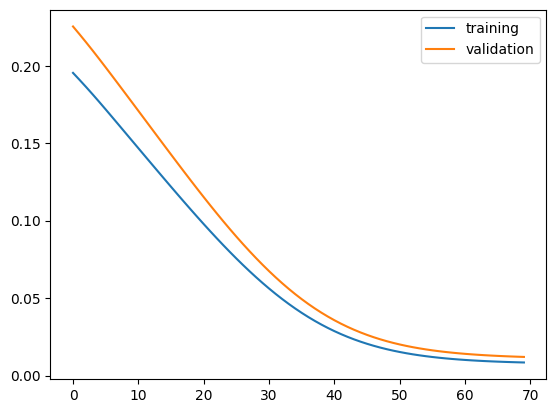

In [27]:
step = 1

plt.plot(losses[::step], label="training")
plt.plot(val_losses[::step],label="validation")
plt.legend()

## Saving model

In [22]:
toSave = SaveObject()
toSave.save_params(params)
toSave.save_forward_pass_params(num_output_channels,ndim,tower_module)

In [23]:
save_path = "./models/example.pickle"

In [24]:
with open(save_path,"wb") as f:
    pickle.dump(toSave,f)

## Loading model

In [25]:
with open(save_path,'rb',) as pickle_file:
    loaded = pickle.load(pickle_file)
    loaded.make_forward_pass()
    loaded.preprocess()

## Predicting with model

In [26]:
num =  34 #int(np.random.rand()*np.shape(X_test)[0]//1)
vel = 0      # 0 is u, 1 is v

pred = loaded.forward_pass.apply(loaded.params,X_test[num,:,:,:])

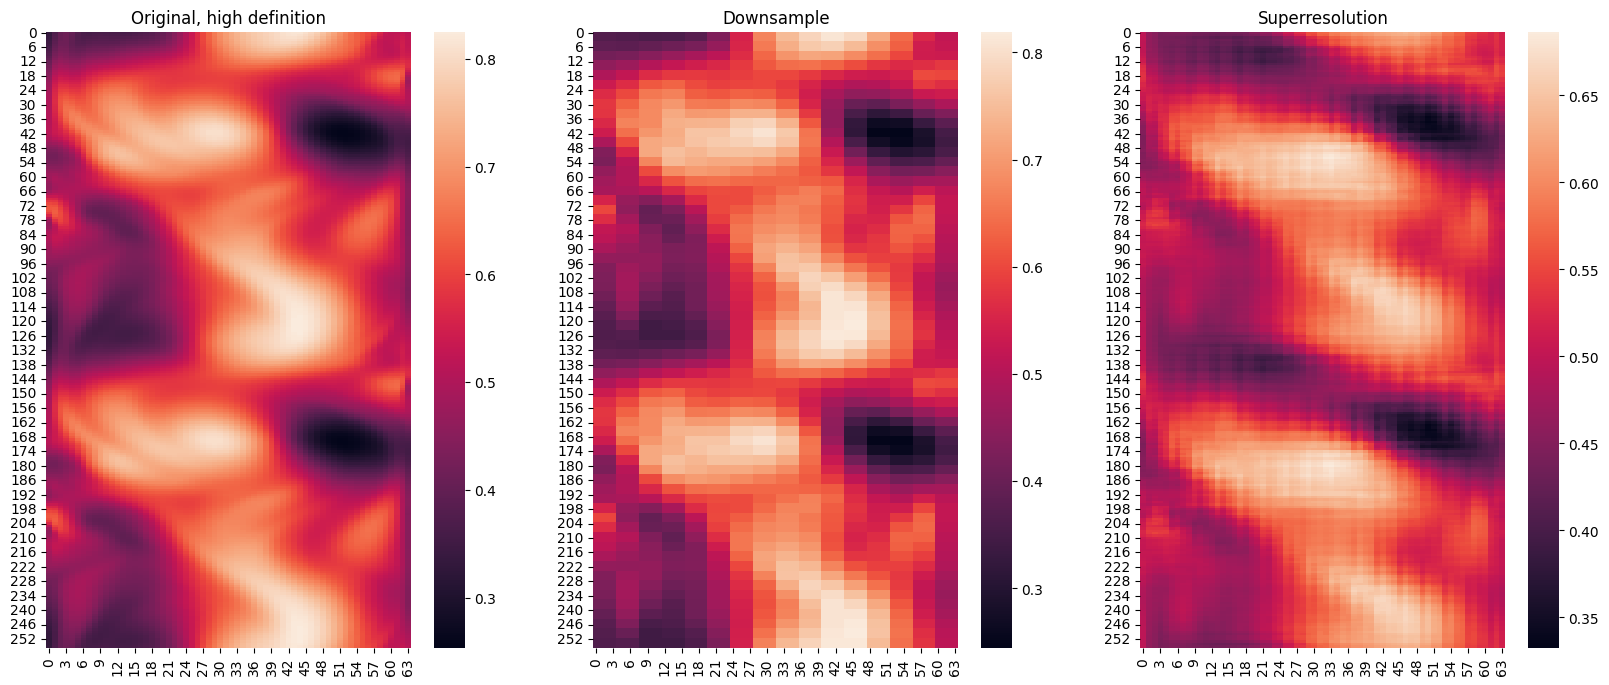

In [84]:
fig, axs = plt.subplots(1,3, facecolor='w', edgecolor='k',figsize=(20,8))
# fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()

im = seaborn.heatmap(Y_test[num,:,:,vel],ax = axs[0])
axs[0].title.set_text("Original, high definition")
im = seaborn.heatmap(X_test[num,:,:,vel],ax = axs[1])
axs[1].title.set_text("Downsample")
im = seaborn.heatmap(pred[:,:,vel],ax = axs[2])
axs[2].title.set_text("Superresolution")

In [85]:
err_before = mse(X_test[num,:,:,vel],Y_test[num,:,:,vel])
err_after = mse(pred[:,:,vel],Y_test[num,:,:,vel])

print("Error before correction: " + str(err_before))
print("Error after correction: " + str(err_after))

if err_after<err_before:
    print("Error reduced by network, nice")
else:
    print("WARNING: error increased by network")

Error before correction: 0.00048274233
Error after correction: 0.0080186045


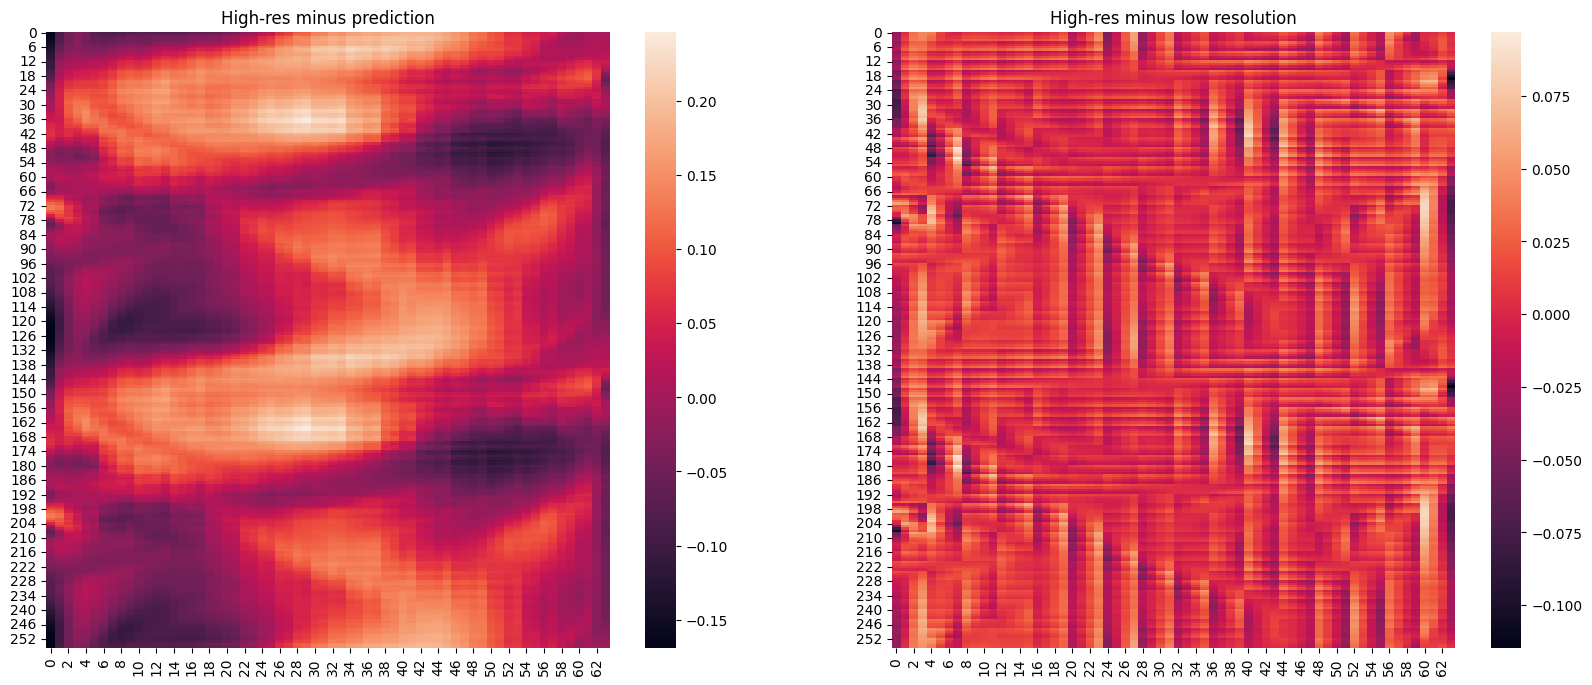

In [86]:
# I think these are called residuals (?)
fig, axs = plt.subplots(1,2, facecolor='w', edgecolor='k',figsize=(20,8))
# fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()

im = seaborn.heatmap(Y_test[num,:,:,vel]-pred[:,:,vel],ax = axs[0])
axs[0].title.set_text("High-res minus prediction")
im = seaborn.heatmap(Y_test[num,:,:,vel]-X_test[num,:,:,vel],ax = axs[1])
axs[1].title.set_text("High-res minus low resolution")

In [92]:
print(mse(pred[:,:,0],pred[:,:,1]))
print(mse(Y_test[num,:,:,0],Y_test[num,:,:,1]))

0.0070195226
0.044490907


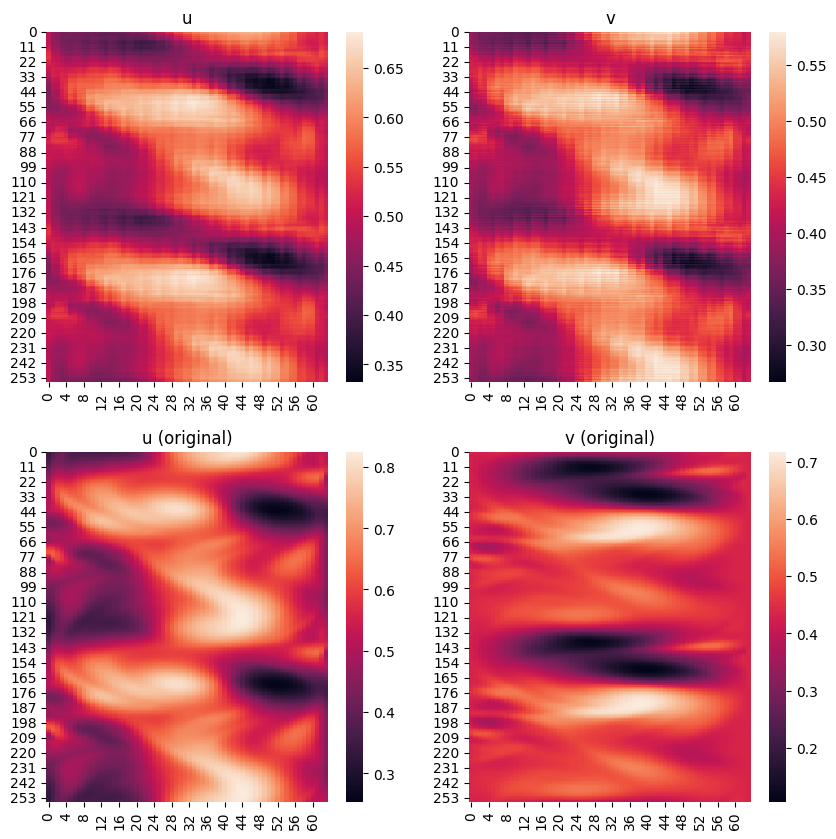

In [93]:
fig, axs = plt.subplots(2,2, facecolor='w', edgecolor='k',figsize=(10,10))
# fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()

im = seaborn.heatmap(pred[:,:,0],ax = axs[0])
axs[0].title.set_text("u")
im = seaborn.heatmap(pred[:,:,1],ax = axs[1])
axs[1].title.set_text("v")

im = seaborn.heatmap(Y_test[num,:,:,0],ax = axs[2])
axs[2].title.set_text("u (original)")
im = seaborn.heatmap(Y_test[num,:,:,1],ax = axs[3])
axs[3].title.set_text("v (original)")